# clip_raster
The purpose of this script is to clip raster file based on polygon 

In [27]:
# import modules 
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
#from fiona.crs import from_epsg
#import pycrs
import os

ModuleNotFoundError: No module named 'pycrs'

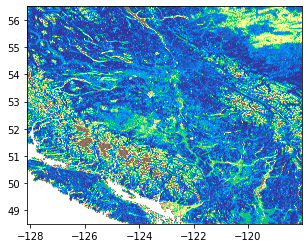

<AxesSubplot:>

In [4]:
# reading input raster and displaying it  
input_raster = 'input/NALCMS_LC_2010_30M_clip_12class.tif'

data = rasterio.open(input_raster)
# Visualize the NIR band
show((data, 1), cmap='terrain')


Here the purpose is to clip the desired raster image to a smaller region of interest using a box. So, we need to define the boundary first. 

In [6]:
# define the box
minx, miny = -126, -124
maxx, maxy = 52, 53
bbox = box(minx, miny, maxx, maxy)

Create a GeoDataFrame from the bounding box

In [10]:
gdf = gpd.GeoDataFrame({'geometry':bbox}, index=[0])
gdf = gdf.set_crs('EPSG:4269')

gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

Next we need to get the coordinates of the geometry in such a format that rasterio wants them. This can be conducted easily with following function:

In [11]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [12]:
coords = getFeatures(gdf)
print(coords)

[{'type': 'Polygon', 'coordinates': [[[52.0, -124.0], [52.0, 53.0], [-126.0, 53.0], [-126.0, -124.0], [52.0, -124.0]]]}]


We need to clip raster file using rasterio

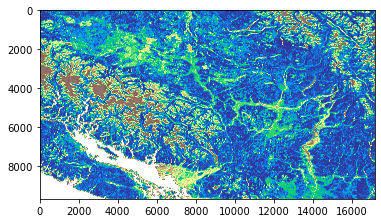

<AxesSubplot:>

In [35]:
# clip the raster with polygon 
clip_lc,out_transform = mask(dataset=data, shapes = coords, crop = True)

# showing clipped lc. The geographical info has not been set
show(clip_lc,cmap='terrain')

In [17]:
# getting the metadata

out_met =data.meta.copy()
print(out_met)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 15.0, 'width': 21742, 'height': 17206, 'count': 1, 'crs': CRS.from_dict(init='epsg:4269'), 'transform': Affine(0.00046473769662404486, 0.0, -128.125816,
       0.0, -0.00046473769662404486, 56.50361780811331)}


In [24]:
# Parse EPSG code
epsg_code = int(data.crs.data['init'][5:])
print(epsg_code)
#print(int(clip_lc.crs.clip_lc['init'][5:]))

4269


In [29]:
# update the meta data 

out_met.update({"driver": "GTiff",
                 "height": clip_lc.shape[1],
                 "width": clip_lc.shape[2],
                 "transform": out_transform})

#clip_lc = clip_lc.set_crs('EPSG:4269'), the crs is incompelete

save the clipped raster. 

In [32]:
#with rasterio.open(clip_lc, "w", **out_met) as dest:
#        dest.write(clip_lc)